# How to think about treating heterogeneous initial populations

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import sys
import pickle
from pyDOE import *
from scipy.stats.distributions import norm

In [3]:
u_N = .02
u_SCM = .005
u_TM = 0.32
u_CM = 0.35
u_EM = 0.30
u_EMRA = 0.005
std = 0.1

u_T = [u_N, u_SCM, u_TM, u_CM,u_EM,u_EMRA]

In [4]:
# Set plotting parameters
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

## Define Model

In [5]:
#Define the model
def model(z,t):
    L_n = z[0]
    L_scm = z[2]
    L_tm = z[4]
    L_cm = z[6] 
    L_em = z[8]
    L_emra = z[10]
    
    A_n = z[1]
    A_scm = z[3]
    A_tm = z[5]
    A_cm = z[7]
    A_em = z[9]
    A_emra = z[11]
    
    
    #for drug dosings
    dL_ndt = (p_n - d_n)*L_n - a*L_n + w*A_n
    dA_ndt = a*L_n - d_ALL*A_n - w*A_n
    
    dL_scmdt = (p_scm - d_scm)*L_scm - a*L_scm + w*A_scm
    dA_scmdt = a*L_scm - d_ALL*A_scm - w*A_scm
    
    dL_tmdt = (p_tm - d_tm)*L_tm - a*L_tm + w*A_tm
    dA_tmdt = a*L_tm - d_ALL*A_tm - w*A_tm
    
    dL_cmdt = (p_cm - d_cm)*L_cm - a*L_cm + w*A_cm
    dA_cmdt = a*L_cm - d_ALL*A_cm - w*A_cm
    
    dL_emdt = (p_em - d_em)*L_em - a*L_em + w*A_em
    dA_emdt = a*L_em - d_ALL*A_em - w*A_em
    
    dL_emradt = (p_emra - d_emra)*L_emra - a*L_emra + w*A_emra
    dA_emradt = a*L_emra - d_ALL*A_emra - w*A_emra
    
    
    dzdt = [dL_ndt,dA_ndt,
            dL_scmdt,dA_scmdt,
            dL_tmdt,dA_tmdt,
            dL_cmdt,dA_cmdt,
            dL_emdt,dA_emdt,
            dL_emradt,dA_emradt
            ]
    return dzdt

In [9]:
LRA_tmp = np.linspace(0,20,21)
d_tmp = np.linspace(0,1,21)
d_ALL_tmp = np.linspace(0,20,21)
parameter_arr_1 = LRA_tmp
parameter_arr_2 = d_tmp
parameter_arr_3 = d_ALL_tmp

In [6]:
LRA_tmp = np.linspace(0,20,21)
d_tmp = np.linspace(0,1,21)
d_ALL_tmp = np.linspace(0,20,21)
parameter_arr_1 = LRA_tmp
parameter_arr_2 = d_tmp
parameter_arr_3 = d_ALL_tmp
parameter_letter = 'LRA'


#number of time points
tn = 2000

#store solutions
L_n = np.zeros([parameter_arr_1.shape[0],parameter_arr_2.shape[0],parameter_arr_3.shape[0], tn])
L_scm = np.zeros([parameter_arr_1.shape[0],parameter_arr_2.shape[0],parameter_arr_3.shape[0], tn])
L_tm = np.zeros([parameter_arr_1.shape[0],parameter_arr_2.shape[0],parameter_arr_3.shape[0], tn])
L_cm = np.zeros([parameter_arr_1.shape[0],parameter_arr_2.shape[0],parameter_arr_3.shape[0], tn])
L_em = np.zeros([parameter_arr_1.shape[0],parameter_arr_2.shape[0],parameter_arr_3.shape[0], tn])
L_emra = np.zeros([parameter_arr_1.shape[0],parameter_arr_2.shape[0],parameter_arr_3.shape[0], tn])

A_n = np.zeros([parameter_arr_1.shape[0],parameter_arr_2.shape[0],parameter_arr_3.shape[0], tn])
A_scm = np.zeros([parameter_arr_1.shape[0],parameter_arr_2.shape[0],parameter_arr_3.shape[0], tn])
A_tm = np.zeros([parameter_arr_1.shape[0],parameter_arr_2.shape[0],parameter_arr_3.shape[0], tn])
A_cm = np.zeros([parameter_arr_1.shape[0],parameter_arr_2.shape[0],parameter_arr_3.shape[0], tn])
A_em = np.zeros([parameter_arr_1.shape[0],parameter_arr_2.shape[0],parameter_arr_3.shape[0], tn])
A_emra = np.zeros([parameter_arr_1.shape[0],parameter_arr_2.shape[0],parameter_arr_3.shape[0], tn])
Total = np.zeros([parameter_arr_1.shape[0],parameter_arr_2.shape[0],parameter_arr_3.shape[0], tn])






for i,parameter_1 in enumerate(parameter_arr_1):
    for j,parameter_2 in enumerate(parameter_arr_2):
        for l, parameter_3 in enumerate(parameter_arr_3):
    #initial conditions, there are three
            w = 1/20 # In Ke's 2015 paper, it looks like a reasonable assumption is 20-50 days because thats where copies of vRNA start dropping
            d = 1
            LRA = 1
            d_ALL = 0.003 * parameter_3#0.003 

            LRA = parameter_1
            d = parameter_2


            #set parameters

            p_cm = 0.00075 * d
            p_tm = 0.0006 * d
            p_em = 0.0003 * d
            p_n = 0.000099 * d
            p_scm = 0.00001 * d
            p_emra = 0.00005 * d


            corr_fact = -np.log(1/2)
            d_n = corr_fact * (1/1500)
            d_scm = corr_fact * (1/150)
            d_tm = corr_fact * (1/100)
            d_cm = corr_fact * (1/120)
            d_em = corr_fact * (1/90)
            d_emra = corr_fact * (1/250)
            n = 0.00017
            a = n * LRA


            z0 = np.zeros(12)
            ctr=0
            for g in range(6):
                z0[ctr] = u_T[g]*10**6
                ctr+=2

            #time points
            b = 2000
            tn = 60001
            t = np.linspace(0,tn-1, b)


            #record intial

            L_n[i][j][l][0] = z0[0]
            L_scm[i][j][l][0] = z0[2]
            L_tm[i][j][l][0] = z0[4]
            L_cm[i][j][l][0] = z0[6] 
            L_em[i][j][l][0] = z0[8]
            L_emra[i][j][l][0] =z0[10]

            A_n[i][j][l][0] = z0[1]
            A_scm[i][j][l][0] = z0[3]
            A_tm[i][j][l][0] = z0[5]
            A_cm[i][j][l][0] = z0[7]
            A_em[i][j][l][0] = z0[9]
            A_emra[i][j][l][0] = z0[11]

            Total[i][j][l][0] = np.sum(z0)



            #Solve the ODE
            for k in range(1,b):
                tspan = [t[k-1],t[k]]
                # solve for next step
                z = odeint(model,z0,tspan)
                # store solution for plotting

                L_n[i][j][l][k] = z[1][0]
                L_scm[i][j][l][k] = z[1][2]
                L_tm[i][j][l][k] = z[1][4]
                L_cm[i][j][l][k] = z[1][6] 
                L_em[i][j][l][k] = z[1][8]
                L_emra[i][j][l][k] = z[1][10]

                A_n[i][j][l][k] = z[1][1]
                A_scm[i][j][l][k] = z[1][3]
                A_tm[i][j][l][k] = z[1][5]
                A_cm[i][j][l][k] = z[1][7]
                A_em[i][j][l][k] = z[1][9]
                A_emra[i][j][l][k] = z[1][11]





                Total[i][j][l][k] =np.sum(z[1])
                z0 = z[1] 


            sys.stdout.write('\r {},{},{}'.format(i,j,l) )

t = t/365
pop_dict = {}
pop_dict['latent'] = [L_n, L_scm, L_tm, L_cm, L_em, L_emra]
pop_dict['active'] = [A_n, A_scm, A_tm, A_cm, A_em, A_emra]
pop_dict['times'] = t
pop_dict['total'] = Total
pop_dict['cell_type'] = ['T_n', 'T_scm', 'T_tm', 'T_cm','T_em', 'T_emra']



 20,20,20

In [7]:
pop_dict['LRA'] = parameter_arr_1
pop_dict['d'] = parameter_arr_2
pop_dict['d_ALL'] = parameter_arr_3

In [1]:
#pickle.dump(pop_dict,open('190506_LRA_d_sensitivity_regTN.p', 'wb'))

In [5]:
pop_dict = pickle.load(open('190506_LRA_d_sensitivity_regTN.p','rb'))

In [6]:
b = 2000
tn = 60001
t = np.linspace(0,tn-1, b)/365
hy_heatmap = np.zeros([21,21,21])
for i in range(21):
    for j in range(21):
        for k in range(21):
            a= np.where(pop_dict['total'][i,j,k] < 10**2)[0]
            if len(a) == 0:
                hy_heatmap[i,j,k] = 0
            else:
                hy_heatmap[i,j,k] = t[a[0]]

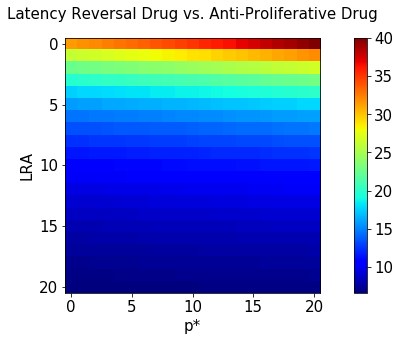

In [10]:
plt.figure(figsize = (10,5))
plt.imshow(hy_heatmap[:,:,19], cmap = 'jet')
plt.colorbar()
plt.ylabel('LRA')
#plt.yticks(np.arange(0, 120, step=20))
plt.xlabel('p*')
#plt.xticks(np.arange(0,125, step = 25),np.arange(0,1.25, step = .25 ))
ttl = plt.title('Latency Reversal Drug vs. Anti-Proliferative Drug', fontsize = 15)
ttl.set_position([0.5, 1.05])
plt.tight_layout()

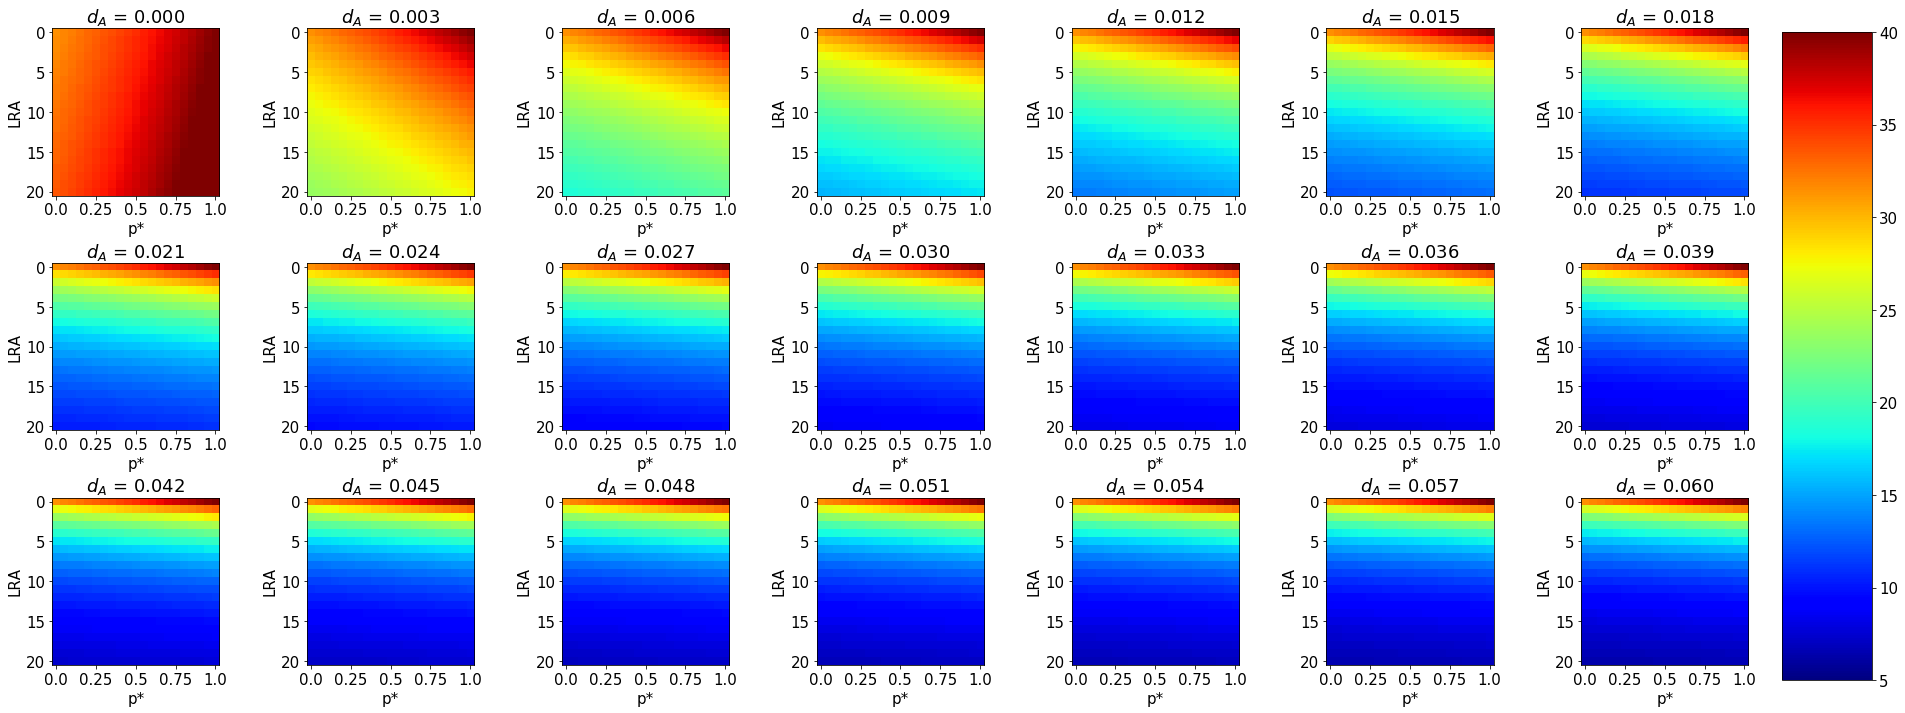

In [16]:
f = plt.figure(figsize=(25,10))

for i in parameter_arr_3:
    ax = f.add_subplot(3,7,i+1)
    im = plt.imshow(hy_heatmap[:,:,int(i)], cmap = 'jet', clim= (5,40))
    plt.ylabel('LRA')
    plt.xticks(np.arange(0,25, step = 5), np.arange(0,100, step = .25))
    plt.xlabel('p*')
    plt.title(r'$d_A$ = {:.3f}'.format(0.003*i))

f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([1, 0.05, 0.05, .9])
f.colorbar(im, cax=cbar_ax)
plt.tight_layout()


In [ ]:
f = plt.figure(figsize=(25,10))

for i in parameter_arr_2:
    ax = f.add_subplot(3,7,i+1)
    im = plt.imshow(hy_heatmap[:,:,int(i)], cmap = 'jet', clim= (5,40))
    plt.ylabel('LRA')
    plt.xticks(np.arange(0,25, step = 5),np.arange(0,1.5, step = .25 ))
    plt.xlabel('p*')
    plt.title('d_ALL = {:.3f}'.format(0.003*i))

f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([1, 0.05, 0.05, .9])
f.colorbar(im, cax=cbar_ax)
plt.tight_layout()


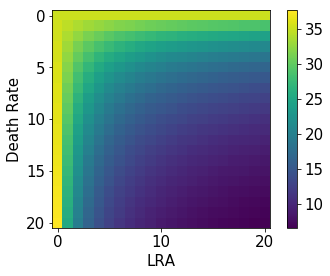

In [99]:
plt.imshow(hy_heatmap[:,10,:])
plt.xlabel('LRA')
plt.ylabel('Death Rate')
plt.colorbar()